<a href="https://colab.research.google.com/github/Ahmed23Adel/Rossmann-sales-prediction/blob/main/self_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

<img src="https://thumbs.dreamstime.com/z/rossmann-store-lubeck-germany-august-people-visit-cosmetics-lubeck-germany-as-had-stores-employees-47478397.jpg"
 width="400px" align="right">

# 0.0 Imports

In [ ]:
from google.colab import files
from IPython.display import clear_output
import pandas as pd
import numpy as np
!pip install ydata-profiling
from pandas_profiling import ProfileReport
import IPython
import seaborn as sns
from collections import defaultdict
!pip install missingno
import missingno as msno
from sklearn.model_selection import train_test_split,GridSearchCV
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
!pip install prophet
from prophet import Prophet
clear_output()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (4,4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


# 1.0 Download the dataset from kaggle

In [ ]:
##### @title Download dataset from kaggle
! pip install -q kaggle
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle competitions download -c rossmann-store-sales
! mkdir comp_data
! unzip /content/rossmann-store-sales.zip -d comp_data
clear_output()

# 2.0 Explore the dataset

In [ ]:
df_store = pd.read_csv("/content/comp_data/store.csv", low_memory = False)
df_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [ ]:
df_train = pd.read_csv("/content/comp_data/train.csv", low_memory = False)
df_train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
df_test = pd.read_csv("/content/comp_data/test.csv", low_memory = False)
df_test.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

Training dataset has the following columns:
1. Id <font color='orange'>Categorical</font> -  an Id that represents
2. Store <font color='orange'>Categorical</font> - a unique Id for each store
3. Sales <font color='green'>Discrete</font>- the turnover for any given day
4. Customers <font color='green'>Discrete</font>- the number of customers on a given day
5. Open <font color='orange'>Nominal</font>- an indicator for whether the store was open: 0 = closed, 1 = open
6. StateHoliday <font color='orange'>Nominal</font>- indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
7. SchoolHoliday <font color='orange'>Nominal</font>- indicates if the (Store, Date) was affected by the closure of public schools
8. StoreType <font color='orange'>Nominal</font>- differentiates between 4 different store models: a, b, c, d
9. Assortment <font color='orange'>Nominal</font>- describes an assortment level: a = basic, b = extra, c = extended
10. CompetitionDistance <font color='green'>Continous</font>- distance in meters to the nearest competitor store
11. CompetitionOpenSince[Month/Year] <font color='green'>discrete</font>- gives the approximate year and month of the time the nearest competitor was opened
12. Promo <font color='orange'>Ordinal</font>- indicates whether a store is running a promo on that day
13. Promo2 <font color='orange'>Ordinal</font>- Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
14. Promo2Since[Year/Week] <font color='orange'>Continous</font>- describes the year and calendar week when the store started participating in Promo2
15. PromoInterval <font color='orange'>Continous</font>- describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

We better merge train with strore dataframe

In [ ]:
df_merge_train = pd.merge(df_train, df_store, on='Store')
df_merge_test = pd.merge(df_test, df_store, on='Store')
print(f"df train had {len(df_train.columns)-1} columns, and store had {len(df_store.columns)-1}, and now both have {len(df_merge_train.columns)-1}")
print(f"df train had {len(df_test.columns)-1} columns, and store had {len(df_store.columns)-1}, and now both have {len(df_merge_test.columns)-1}")

df_merge_train.sample(2)


df train had 8 columns, and store had 9, and now both have 17
df train had 7 columns, and store had 9, and now both have 16


Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
596643    655          4  2013-11-07   7588        623     1      1   
299518    330          1  2015-05-04   5299        532     1      1   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
596643            0              0         d          c                960.0   
299518            0              0         a          c                370.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
596643                       11.0                    2012.0       1   
299518                        NaN                       NaN       1   

        Promo2SinceWeek  Promo2SinceYear     PromoInterval  
596643              5.0           2013.0   Feb,May,Aug,Nov  
299518             22.0           2012.0  Mar,Jun,Sept,Dec

In [ ]:
# Split the data into features (X) and target variable (y)
X = df_merge_train.drop('Sales', axis=1)
y = df_merge_train['Sales']

# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
df_merge_train['Customers']

0          555
1          546
2          523
3          560
4          612
          ... 
1017204    339
1017205    326
1017206    300
1017207    305
1017208      0
Name: Customers, Length: 1017209, dtype: int64

#3.0 Data summary

In [ ]:
df_merge_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
df_merge_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [ ]:
df_merge_train[['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].describe()

Sales     Customers  CompetitionDistance  \
count  1.017209e+06  1.017209e+06         1.014567e+06   
mean   5.773819e+03  6.331459e+02         5.430086e+03   
std    3.849926e+03  4.644117e+02         7.715324e+03   
min    0.000000e+00  0.000000e+00         2.000000e+01   
25%    3.727000e+03  4.050000e+02         7.100000e+02   
50%    5.744000e+03  6.090000e+02         2.330000e+03   
75%    7.856000e+03  8.370000e+02         6.890000e+03   
max    4.155100e+04  7.388000e+03         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  
count              693861.000000             693861.000000  
mean                    7.222866               2008.690228  
std                     3.211832                  5.992644  
min                     1.000000               1900.000000  
25%                     4.000000               2006.000000  
50%                     8.000000               2010.000000  
75%                    10.000000               2013.000000  
max                    12.000000               2015.000000

We can observe that the std of sales is very large, indicating there are great variations based on the day.

the data might be a little old we see that max competition open since the year 2015, but since now is 2023 and many things changed like corona virus which affected the mentality of many people the model may not generalize nowadays sales

# 4.0 EDA
Plots I need to make
1. Descriptive statistics for  Sales, Customers, CompetitionDistance,
1. histogram for sales, customers, CompetitionDistance
3. customers vs sales
4. barplot for categorical variables: StoreType, Assortment, StateHoliday
5. numerical plots for numical variables to detect outliers
6. Line Plots: Plot line graphs to observe the trends and patterns in time-related variables such as Sales over different dates or months

Questions I need to answer
1. Do different store types have varying sales patterns during state holidays when the store is open? Analyze how sales differ across store types (a, b, c, d) on state holidays, considering whether the store is open or closed.
2. How can open affect sales? when the store is closed for one day, how is the sales for the next day?
3. How is the sales like when the there is a state holiday but the store is still open? is it less than average? or greater than average?
4. what are the relationships between store type and sales?
5. what is the relationship between storetype and customer? do pepole tend to visit some certain store more than others? does that have direct effect of sales?
6. Does the proximity to a competitor store affect sales? Investigate how the competition distance correlates with sales and whether stores with closer competitors have lower sales. is there some threshold that for compitiion distance for great sales?
7. how much the increase in sales for after the promo? is it worth it?
8. How does the assortment level (basic, extra, extended) relate to sales? Is there a significant difference in sales between different assortment levels?
9. What is the impact of school holidays on sales?
10. How does the duration of Promo2 promotion affect sales?
11. What is the effect of different types of state holidays (public holiday, Easter holiday, Christmas) on sales when the store is open? Compare sales during different types of state holidays to identify any variations in sales patterns.
12. How does the day of the week impact sales? Analyze the sales trends across different days of the week to identify any patterns or variations.
13. Does the length of the promo interval (months) affect sales? Explore whether longer promo intervals lead to higher sales compared to shorter intervals.
14. Is there a seasonal variation in the relationship between promotions and sales? Analyze whether the impact of promotions (Promo and Promo2) on sales differs across different months or seasons, taking into account the store type and assortment level.
15. What is the combined effect of competition distance, state holidays, and assortment level on sales? Explore the interplay between these factors and their collective influence on the sales performance of stores.
16. for the same store, what are the circumstances that yielded a great sales
17. Which day has the most Customers
18. Which day has the Promotion?
19. Which store has the more Customers?
20. Which month has the highest sales price?
21. Which month has the highest number of Customers?
22. Which day has the highest sales price?
23. Which day the highest Customer number?




### 4.0 Descriptive

I can use profile report libarary it automates all basic statistics i want

In [ ]:
profile = ProfileReport(df_merge_train)
profile.to_file("/content/report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
IPython.display.HTML(filename='/content/report.html')

Insights from profiler:

<font color="orange">Read number</font>

<font color="yellow">Store</font>:
1. we have only 1115 distinct stores in the dataset


<font color="yellow">Day of week</font>:
1. The distribution is uniform for all days which is very good for our model

<font color="yellow">Sales</font>:
1. It's normal distribution with some some outliers
2. there are many observations with zero sales, that could be days when it's closed or holiday or for some other reasons
3. Mean = 5774, STD = 3849
4. There are 172871 out of 1017209 with zeros which represents 17% of our dataset



<font color="yellow">Customers</font>:
1. Normal distribution with great outliers in zeros
2. Mean 633= , STD = 464
3. There are 172869 out of 1017209 with zeros which represents 17% of our dataset, it's very close to number of zeros in sales; we will explore it later


<font color="yellow">Open</font>:
1. 844392 observations is open and 172817 is closed; meaning 83% of the observations is open
2. we notice here data is not balanced in terms of openness
3. notice when store is closed the sales must be zero, that could be beneficial for our post-processing

<font color="yellow">Promo</font>:
1. the dataset only participate in promotion for only 60% of the time
2. number of zeros is about one and half doulb of ones, which might need for normalization when exploring this column



<font color="yellow">StateHoliday</font>:
1. most of the observations is when there are not holidays
2. only 3% of data is when there is holiday


<font color="yellow">SchoolHoliday</font>:
1. 80% of data is when there is no holiday

<font color="yellow">StoreType</font>:
1. the dominant store type is "a" and all of the others types are less than half of datasets
2. that requires normalization when working on it

<font color="yellow">CompetitionDistance</font>:
1. it's right skewed data, many competitiors are very near to the store
<font color="yellow">CompetitionOpenSinceYear</font>:






### 4.0 Descriptive:: customers vs sales

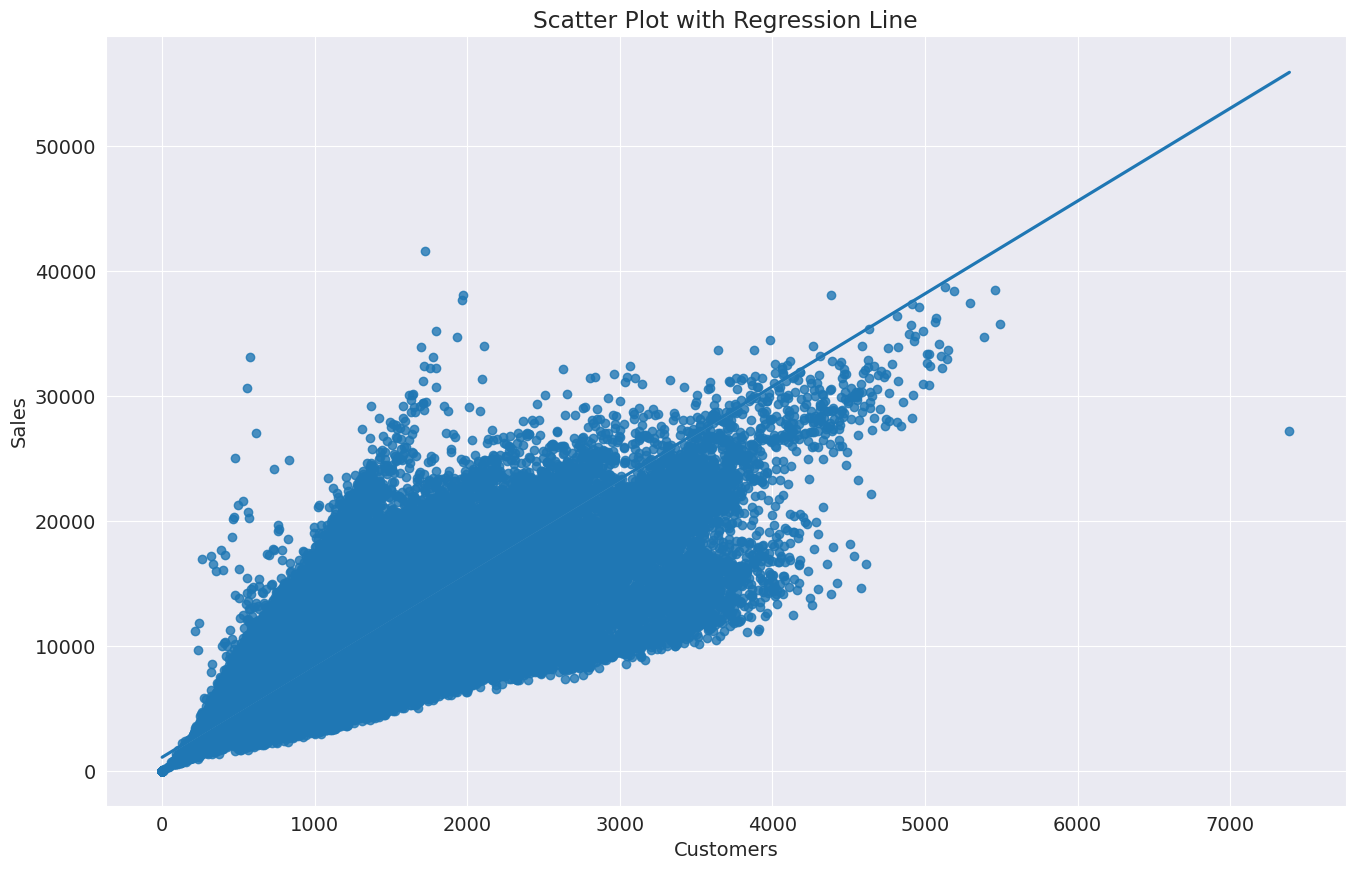

In [ ]:
sns.regplot(x=df_merge_train['Customers'], y=df_merge_train['Sales'])

# Add labels to the axes and a title
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.title('Scatter Plot with Regression Line')

# Display the plot
plt.show()

we see here the relationship between customers and sales is linear, which will be beneficial for any linear model

### 4.1 Do different store types have varying sales patterns during state holidays

when the store is open? Analyze how sales differ across store types (a, b, c, d) on state holidays, considering whether the store is open or closed.

There are 4 different store types compensating the dataset

Text(0.5, 1.0, 'Distribution of store type')

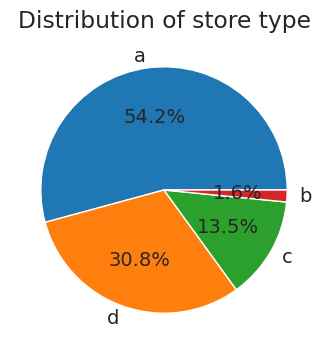

In [ ]:
matplotlib.rcParams['figure.figsize'] = (4,4)
store_types_count = df_merge_train['StoreType'].value_counts()
labels = store_types_count.index
values = store_types_count.values
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of store type')


Now plotting sales vs date for all combinations for storetype and stateholiday

In [ ]:
store_types = df_merge_train['StoreType'].unique()
state_holidays = df_merge_train['StateHoliday'].unique()
df_merge_train_open = df_merge_train[df_merge_train['Open'] == 1]
for i, store_type in enumerate(store_types):
    for j, state_holiday in enumerate(state_holidays):
      filtered_data = df_merge_train_open[(df_merge_train_open['StoreType'] == store_type) & (df_merge_train_open['StateHoliday'] == state_holiday)]
      print(f"For StoreType {store_type} and StateHoliday {state_holiday}, the mean for sales: {filtered_data['Sales'].mean():.2f}")


For StoreType c and StateHoliday 0, the mean for sales: 6932.16
For StoreType c and StateHoliday a, the mean for sales: 7541.38
For StoreType c and StateHoliday b, the mean for sales: nan
For StoreType c and StateHoliday c, the mean for sales: nan
For StoreType a and StateHoliday 0, the mean for sales: 6926.31
For StoreType a and StateHoliday a, the mean for sales: 5374.98
For StoreType a and StateHoliday b, the mean for sales: 2835.25
For StoreType a and StateHoliday c, the mean for sales: 4240.25
For StoreType d and StateHoliday 0, the mean for sales: 6822.45
For StoreType d and StateHoliday a, the mean for sales: 6439.94
For StoreType d and StateHoliday b, the mean for sales: 3092.22
For StoreType d and StateHoliday c, the mean for sales: 1800.00
For StoreType b and StateHoliday 0, the mean for sales: 10178.56
For StoreType b and StateHoliday a, the mean for sales: 12056.51
For StoreType b and StateHoliday b, the mean for sales: 13038.45
For StoreType b and StateHoliday c, the mean 

In [ ]:
state_holidays

array(['0', 'a', 'b', 'c'], dtype=object)

For StoreType c and StateHoliday a, len = 65, the mean for sales: 7541.38, std  = 2286.90
For StoreType c and StateHoliday b, len = 0, the mean for sales: nan, std  = nan
For StoreType c and StateHoliday c, len = 0, the mean for sales: nan, std  = nan


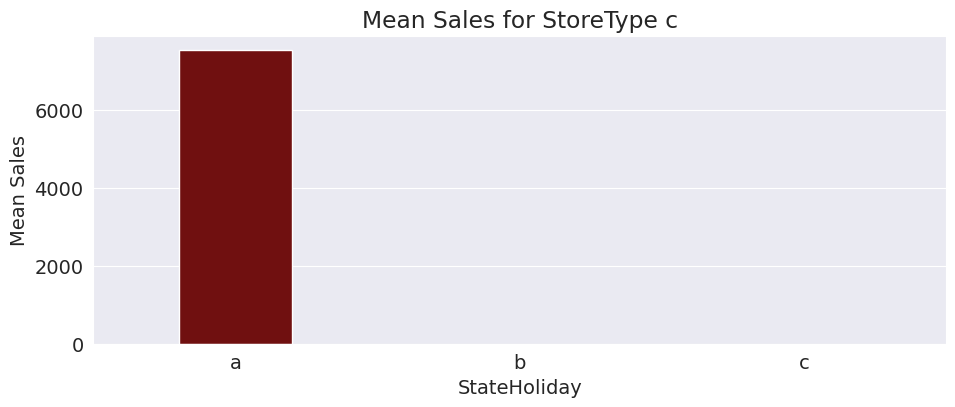

For StoreType a and StateHoliday a, len = 236, the mean for sales: 5374.98, std  = 3082.68
For StoreType a and StateHoliday b, len = 36, the mean for sales: 2835.25, std  = 1632.19
For StoreType a and StateHoliday c, len = 4, the mean for sales: 4240.25, std  = 490.33


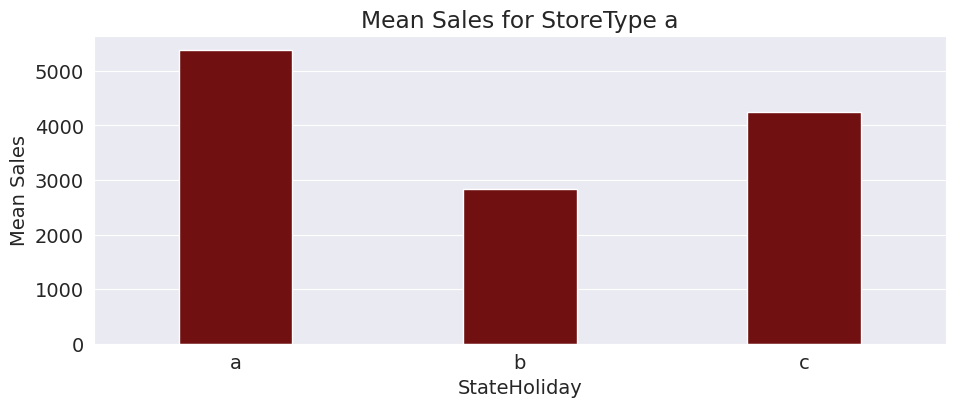

For StoreType d and StateHoliday a, len = 108, the mean for sales: 6439.94, std  = 3098.36
For StoreType d and StateHoliday b, len = 9, the mean for sales: 3092.22, std  = 1320.94
For StoreType d and StateHoliday c, len = 1, the mean for sales: 1800.00, std  = nan


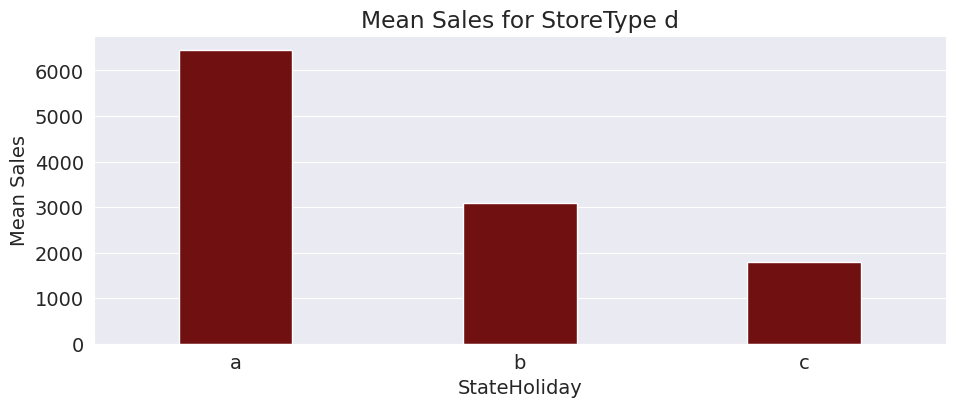

For StoreType b and StateHoliday a, len = 285, the mean for sales: 12056.51, std  = 6650.51
For StoreType b and StateHoliday b, len = 100, the mean for sales: 13038.45, std  = 7039.69
For StoreType b and StateHoliday c, len = 66, the mean for sales: 10197.65, std  = 5955.44


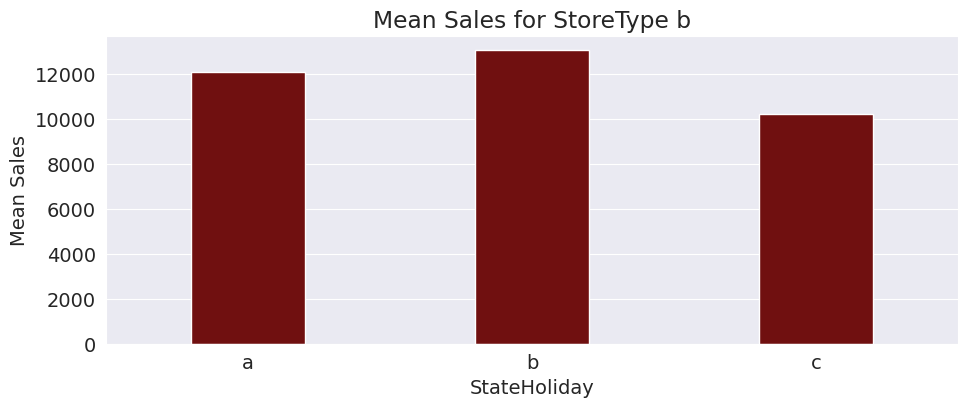

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

store_types = df_merge_train['StoreType'].unique()
state_holidays = df_merge_train['StateHoliday'].unique()
state_holidays = np.delete(state_holidays, np.where(state_holidays == '0'))

df_merge_train_open = df_merge_train[df_merge_train['Open'] == 1]

# Iterate over each store type
for store_type in store_types:
    # Filter the data for the current store type
    filtered_data = df_merge_train_open[df_merge_train_open['StoreType'] == store_type]

    # Create a new figure and axis for each store type
    fig, ax = plt.subplots(figsize=(11, 4))

    means = []
    for state_holiday in state_holidays:
        _filtered_data =  filtered_data[filtered_data['StateHoliday'] == state_holiday]
        mean_sales = filtered_data[filtered_data['StateHoliday'] == state_holiday]['Sales'].mean()
        means.append(mean_sales)
        print(f"For StoreType {store_type} and StateHoliday {state_holiday}, len = {len(_filtered_data)}, the mean for sales: {_filtered_data['Sales'].mean():.2f}, std  = {_filtered_data['Sales'].std():.2f}")


    # Plot the mean sales for each state holiday
    sns.barplot(x=state_holidays, y=means, color='maroon', width=0.4)

    # Set title and labels for the plot
    ax.set_title(f"Mean Sales for StoreType {store_type}")
    ax.set_xlabel('StateHoliday')
    ax.set_ylabel('Mean Sales')

    # Show the plot for the current store type
    plt.show()


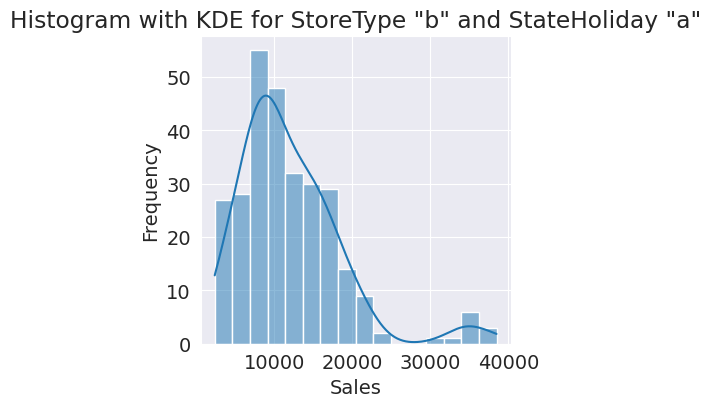

In [ ]:
subset_data = df_merge_train_open[(df_merge_train_open['StoreType'] == "b") & (df_merge_train_open['StateHoliday'] == 'a')]
sns.histplot(data=subset_data, x='Sales', kde=True)
# Add labels and title
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram with KDE for StoreType "b" and StateHoliday "a"')
# Display the plot
plt.show()

Normal distribution with some outliers

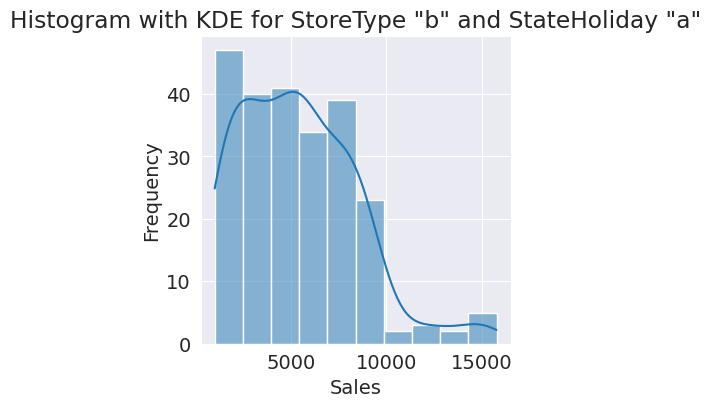

In [ ]:
subset_data = df_merge_train_open[(df_merge_train_open['StoreType'] == "a") & (df_merge_train_open['StateHoliday'] == 'a')]
sns.histplot(data=subset_data, x='Sales', kde=True)
# Add labels and title
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Histogram with KDE for StoreType "b" and StateHoliday "a"')
# Display the plot
plt.show()

Final thoughts:
1. It is important to note that the analysis conducted may not be highly accurate due to insufficient data for all types of holidays and store types.
2. Among the store types, store type "b" achieved the highest mean sales of 12,056 when it was a public holiday. Conversely, store type "a" recorded the lowest mean sales for the same type of holiday.
3. However, it is worth mentioning that there is a significant standard deviation of 6650 for store type "b", indicating a large variability in sales data for this store type.

### 4.2 How can open affect sales? when the store is closed for one day, how is the sales for the next day?

i want first make sure for closed days the next day observation is present in the data

In [ ]:
df_merge_train[df_merge_train['Open'] == 0].iloc[1,:]

Store                                 1
DayOfWeek                             7
Date                         2015-07-19
Sales                                 0
Customers                             0
Open                                  0
Promo                                 0
StateHoliday                          0
SchoolHoliday                         0
StoreType                             c
Assortment                            a
CompetitionDistance              1270.0
CompetitionOpenSinceMonth           9.0
CompetitionOpenSinceYear         2008.0
Promo2                                0
Promo2SinceWeek                     NaN
Promo2SinceYear                     NaN
PromoInterval                       NaN
Name: 12, dtype: object

In [ ]:
df_merge_train[(df_merge_train['Date'] == '2015-07-21')&((df_merge_train['Store'] == 1))]

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
10      1          2  2015-07-21   3558        469     1      0            0   

    SchoolHoliday StoreType Assortment  CompetitionDistance  \
10              0         c          a               1270.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
10                        9.0                    2008.0       0   

    Promo2SinceWeek  Promo2SinceYear PromoInterval  
10              NaN              NaN           NaN

I tried several random days, and actually yes they are present

The plot i want to do
for some certain store type: pllot sales vs Date for a 3 days before and 3 days after the day when the store was close. and focus on day after close to be of different color.

In [ ]:
subset_data = df_merge_train[(df_merge_train['Date'] == '2015-07-19')&((df_merge_train['Store'] == 1))]
date_before = pd.to_datetime(subset_data['Date']) - pd.DateOffset(days=3)
date_after = pd.to_datetime(subset_data['Date']) + pd.DateOffset(days=3)
filtered_data = df_merge_train[(pd.to_datetime(df_merge_train['Date']) >= date_before.iloc[0]) & (pd.to_datetime(df_merge_train['Date']) <= date_after.iloc[0]) & ((df_merge_train['Store'] == 1))]
len(filtered_data)

7

In [ ]:
for index, row in filtered_data.iterrows():
    sales = row['Sales']
    print(sales)


4782
5011
6102
0
4364
3706
3769


<Figure size 1000x600 with 0 Axes>

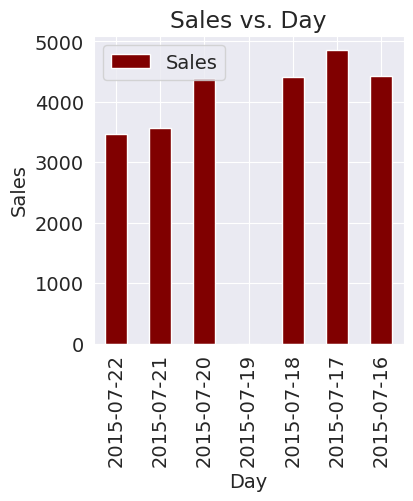

In [ ]:
plt.figure(figsize=(10, 6))
filtered_data.plot(x='Date', y='Sales', kind='bar', color='maroon')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.title('Sales vs. Day')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data for closed days
closed_data = df_merge_train[df_merge_train['Open'] == 0]

# Calculate the date range (3 days before and 3 days after) for each closed day
closed_data['Date'] = pd.to_datetime(closed_data['Date'])
closed_data['Date_before'] = closed_data['Date'] - pd.DateOffset(days=3)
closed_data['Date_after'] = closed_data['Date'] + pd.DateOffset(days=3)

# Initialize a list to store the mean sales for each closed day
mean_sales_days = defaultdict(int)

# Iterate over the closed days and calculate the mean sales
for index, row in closed_data.sample(1000).iterrows():
    date_before = row['Date_before']
    date_after = row['Date_after']
    store_id = row['Store']

    filtered_data = df_merge_train[
        (pd.to_datetime(df_merge_train['Date']) >= date_before) &
        (pd.to_datetime(df_merge_train['Date']) <= date_after) &
        (df_merge_train['Store'] == store_id)
    ]
    day = 1
    for index, row in filtered_data.iterrows():
      mean_sales_days[day] += row['Sales']
      day += 1
clear_output()


<ipython-input-168-596814a29245>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_data['Date'] = pd.to_datetime(closed_data['Date'])
<ipython-input-168-596814a29245>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_data['Date_before'] = closed_data['Date'] - pd.DateOffset(days=3)
<ipython-input-168-596814a29245>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

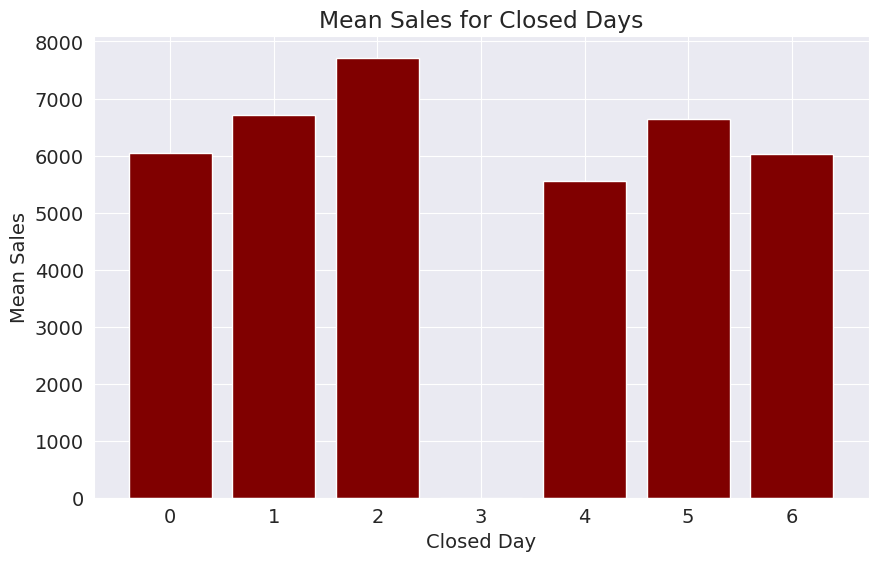

For day 1 mean value = 6051860
For day 2 mean value = 6718921
For day 3 mean value = 7715496
For day 4 mean value = 0
For day 5 mean value = 5555622
For day 6 mean value = 6649690
For day 7 mean value = 6028615


In [ ]:
# Plot mean sales for closed days
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_sales_days.values())), [x/1000 for x in mean_sales_days.values()], color='maroon')
plt.xlabel('Closed Day')
plt.ylabel('Mean Sales')
plt.title('Mean Sales for Closed Days')
plt.show()
for i in range(1,8):
  print(f"For day {i} mean value = {mean_sales_days[i]}")

In [ ]:
# 7715496 - max(6051860,6718921,5555622, 6649690, 6028615 )
# 996575 / max(6051860,6718921,5555622, 6649690, 6028615 )
# 5555622/max(6051860,6718921,5555622, 6649690, 6028615 )

0.8268622298133882

<font color ="yellow">Final thoughts:</font>
1. Due to the prolonged processing time for the complete dataset, I made use of a sampled subset of the data for analysis.
2. Despite working with a sample, a discernible pattern emerges in the mean values. Notably, the mean sales for the day preceding a day-off consistently exhibit the highest values, surpassing other days by an average of 14%.
3. Conversely, the day immediately following a holiday experiences a significant decline in sales, with the mean value reaching its lowest point, approximately 18% lower than the overall average.
4. It remains challenging to ascertain whether this decline solely stems from the holiday itself or if it is influenced by post-holiday effects. Notably, individuals may be more inclined to venture outside their homes even after a holiday, impacting sales figures. Further investigation is necessary to unravel the underlying factors contributing to these observed trends and their precise implications on sales performance.


### 4.3 How is the sales like when the there is a state holiday but the store is still open? is it less than average? or greater than average?

for usual days when ther is no holiday

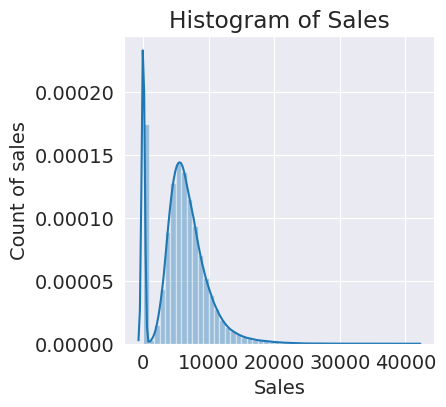

In [ ]:
no_hol = df_merge_train[(df_merge_train['StateHoliday'] == "0")]

sns.distplot(no_hol['Sales'], kde=True, bins=50)

# Setting labels and title
plt.xlabel('Sales')
plt.ylabel('Count of sales')
plt.title('Histogram of Sales')
clear_output()
# Display the plot
plt.show()

In [ ]:
print(df_merge_train[(df_merge_train['StateHoliday'] == "0")]['Sales'].mean())

5947.48389255688


The distribution is exactly normal with many zeros

<ipython-input-193-8a86822e5920>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(no_hol['Sales'], kde=True, bins=50)


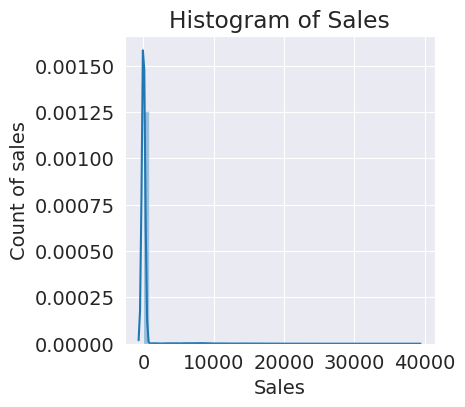

In [ ]:
no_hol = df_merge_train[(df_merge_train['StateHoliday'] != "0") & (df_merge_train['Open'] == "1")]

sns.distplot(no_hol['Sales'], kde=True, bins=50)

# Setting labels and title
plt.xlabel('Sales')
plt.ylabel('Count of sales')
plt.title('Histogram of Sales')
clear_output()
# Display the plot
plt.show()

In [ ]:
print(df_merge_train[(df_merge_train['StateHoliday'] != "0") & (df_merge_train['Open'] == "1")]['Sales'].mean())

nan


Actually there is no data when there was a holiday but the store is still open

### 4.4 what are the relationships between store type and sales?

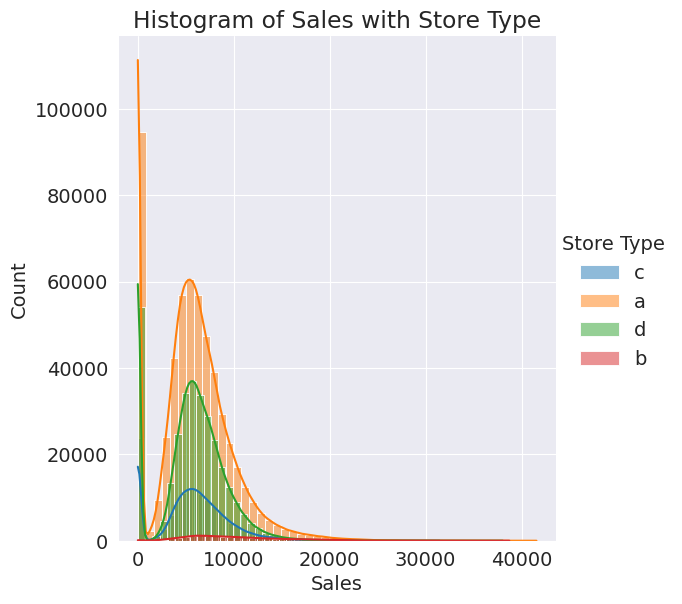

In [ ]:
g = sns.FacetGrid(df_merge_train, hue="StoreType", height=6)

# Map a histogram plot to each subplot
g.map(sns.histplot, "Sales", bins=50, kde=True)

# Add a legend
g.add_legend(title="Store Type")

# Set labels and title
plt.xlabel("Sales")
plt.ylabel("Count")
plt.title("Histogram of Sales with Store Type")

# Show the plot
plt.show()

In [ ]:
for store_type in ['a','b','c','d']:
  f_df = df_merge_train[df_merge_train['StoreType'] == store_type ]
  print(f"For store type {store_type}, the mean value for sales is {f_df['Sales'].mean():.2f}")

For store type a, the mean value for sales is 5738.18
For store type b, the mean value for sales is 10058.84
For store type c, the mean value for sales is 5723.63
For store type d, the mean value for sales is 5641.82


<font color ="yellow">Final thoughts:</font>
1. There is a clear an increase in the sales for store type "b" by  about 4k it's nearly the double of other types

### 4.5 what is the relationship between storetype and customer? do pepole tend to visit some certain store more than others? does that have direct effect of sales?

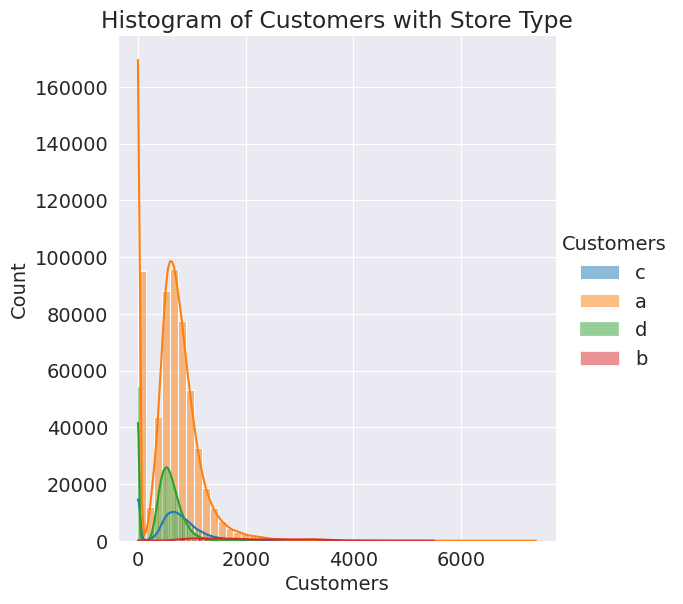

In [ ]:
g = sns.FacetGrid(df_merge_train, hue="StoreType", height=6)

# Map a histogram plot to each subplot
g.map(sns.histplot, "Customers", bins=50, kde=True)

# Add a legend
g.add_legend(title="Customers")

# Set labels and title
plt.xlabel("Customers")
plt.ylabel("Count")
plt.title("Histogram of Customers with Store Type")

# Show the plot
plt.show()

In [ ]:
for store_type in ['a','b','c','d']:
  f_df = df_merge_train[df_merge_train['StoreType'] == store_type ]
  print(f"For store type {store_type}, the mean value for sales is {f_df['Customers'].mean():.2f}")

For store type a, the mean value for sales is 659.03
For store type b, the mean value for sales is 1987.72
For store type c, the mean value for sales is 673.27
For store type d, the mean value for sales is 501.43


<font color ="yellow">Final thoughts:</font>

1. We have observed a strong linear relationship between the number of customers and sales. Among all the store types, store type "b" consistently exhibits the highest mean number of customers. This indicates a higher customer engagement and potentially more foot traffic in these stores.
2. Remarkably, store type "b" surpasses the other types by a substantial margin, with approximately three times the mean number of customers compared to the average across all types. This suggests that store type "b" attracts significantly more customers, potentially due to various factors such as its location, marketing strategies, or product offerings.

# 5.0 Missing values
There are several ways to fill the missing values, so i will prepare multiples of them to find best one to the model

method #1

method #2

method #3

### 5.1 Null means there is no promo

In [ ]:
df_merge_train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

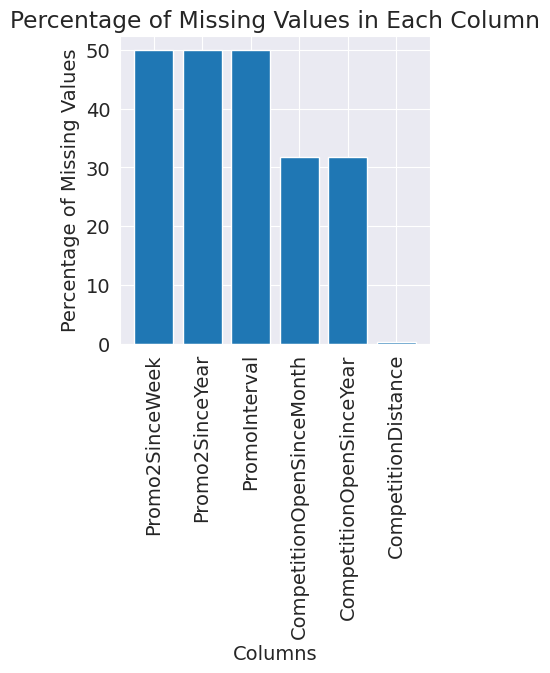

In [ ]:
missing_percentage = df_merge_train.isnull().mean() * 100
missing_percentage= missing_percentage[missing_percentage>0]
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

plt.bar(missing_percentage_sorted.index, missing_percentage_sorted)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.xticks(rotation=90)
plt.show()


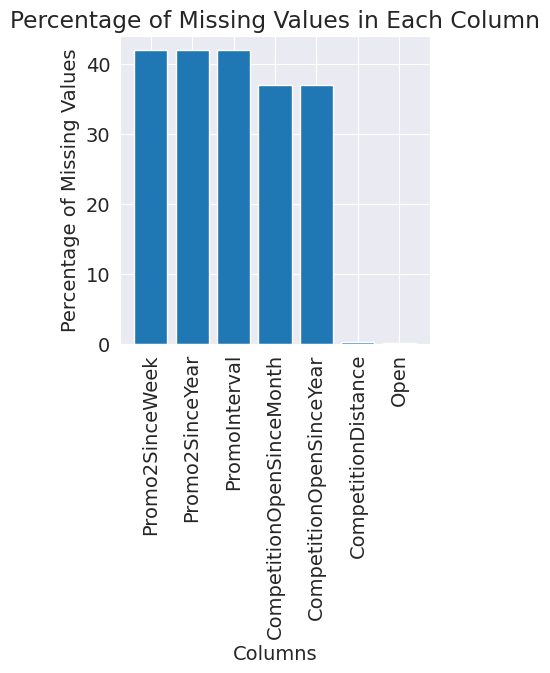

In [ ]:
missing_percentage = df_merge_test.isnull().mean() * 100
missing_percentage= missing_percentage[missing_percentage>0]
missing_percentage_sorted = missing_percentage.sort_values(ascending=False)

plt.bar(missing_percentage_sorted.index, missing_percentage_sorted)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Column')
plt.xticks(rotation=90)
plt.show()


There might be an interpretation for null values in competitiondistance, it could mean that the compititor is very far away; so we can replace it with double of its max

In [ ]:
X_train_trial1, X_test_trial1, y_train_trial1, y_test_trial1 = X_train.copy(deep=True), X_test.copy(deep=True), y_train.copy(deep=True), y_test.copy(deep=True)
df_merge_test_trial1 = df_merge_test.copy(deep=True)

There is about 50% of missing data in promo2sinceweek and promo2sinceyear and promo2Interval

That could be due to that there is no promo2. so lets check it


In [ ]:
print(f"There are {len(X_train_trial1[X_train_trial1['Promo2'] == 0])} rows with nulls in Promo2")
print(f"There are {X_train_trial1['Promo2SinceWeek'].isna().sum()} rows with nulls in Promo2SinceWeek")
print(f"There are {X_train_trial1['Promo2SinceYear'].isna().sum()} rows with nulls in Promo2SinceYear")
print(f"There are {X_train_trial1['PromoInterval'].isna().sum()} rows with nulls in PromoInterval")
print(f"There are {X_train_trial1['CompetitionOpenSinceMonth'].isna().sum()} rows with nulls in CompetitionOpenSinceMonth")
print(f"There are {X_train_trial1['CompetitionOpenSinceYear'].isna().sum()} rows with nulls in CompetitionOpenSinceYear")


There are 406660 rows with nulls in Promo2
There are 406660 rows with nulls in Promo2SinceWeek
There are 406660 rows with nulls in Promo2SinceYear
There are 406660 rows with nulls in PromoInterval
There are 258518 rows with nulls in CompetitionOpenSinceMonth
There are 258518 rows with nulls in CompetitionOpenSinceYear


we can make all missing values with a constant to let the model understand that they belong to the same category


In [ ]:
X_train_trial1.loc[X_train_trial1['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = dt.datetime.now().year
X_train_trial1.loc[X_train_trial1['PromoInterval'].isna(), 'PromoInterval'] = "NA"
X_train_trial1.loc[X_train_trial1['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = dt.datetime.now().isocalendar()[1]
X_train_trial1.loc[X_train_trial1['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.datetime.now(). month
X_train_trial1.loc[X_train_trial1['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.datetime.now().year

df_merge_test_trial1.loc[df_merge_test_trial1['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = dt.datetime.now().year
df_merge_test_trial1.loc[df_merge_test_trial1['PromoInterval'].isna(), 'PromoInterval'] = "NA"
df_merge_test_trial1.loc[df_merge_test_trial1['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = dt.datetime.now().isocalendar()[1]
df_merge_test_trial1.loc[df_merge_test_trial1['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.datetime.now(). month
df_merge_test_trial1.loc[df_merge_test_trial1['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.datetime.now().year
df_merge_test_trial1.loc[df_merge_test_trial1['Open'].isna(), 'Open'] = 0


In [ ]:
print(f"there are {X_train_trial1.isna().sum().sum()} nulls in the dataset now")
print(f"there are {df_merge_test_trial1.isna().sum().sum()} nulls in the dataset now")

there are 2099 nulls in the dataset now
there are 96 nulls in the dataset now


###5.2 Transformers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class fillCompetitionDistance2max(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.max_distance = -1

    def fit(self, df, y=None):
        # Estimate the parameter during fitting
        self.max_distance = X.CompetitionDistance.max()
        #X['CompetitionDistance'].fillna(self.max_distance*2, inplace=True)
        return self

    def transform(self, X):
        # Apply your desired logic during transformation
        # using the estimated parameter
        X['CompetitionDistance'].fillna(self.max_distance*2, inplace=True)
        return X

class fillMonthYearWithCurrentTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None):
        # Estimate the parameter during fitting
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        df.loc[df['Promo2SinceYear'].isna(), 'Promo2SinceYear'] = dt.datetime.now().year
        df.loc[df['Promo2SinceWeek'].isna(), 'Promo2SinceWeek'] = dt.datetime.now().isocalendar()[1]
        df.loc[df['PromoInterval'].isna(), 'PromoInterval'] = "NA"
        df.loc[df['CompetitionOpenSinceMonth'].isna(), 'CompetitionOpenSinceMonth'] = dt.datetime.now(). month
        df.loc[df['CompetitionOpenSinceYear'].isna(), 'CompetitionOpenSinceYear'] = dt.datetime.now().year
        return df


# 6.0 Feature engineering
things might take place in pipeling

1. DayOfWeek:: it's nominal so no logic to use Label encoding. So **oneHotEncoding**
2. indicate weekend flag, before close flag, after close flag
3. Date: split into year, month , day they will be numeric
4. StateHoliday, StoreType:: **oneHotEncoding**
5. find max date in dataset and subtract the compititionSince from max date and make new column
6. Assortment:: **oneHotEncoding**
7. standard scaler for customers,competition distance,


comptition distance since  and data

### 6.1 One hot encoding:

DayOfWeek, StateHoliday, StoreType, Assortment, Promolnterval

In [ ]:
class HandleOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, print_cols = False):
        self.print_cols =print_cols

    def fit(self, df, y=None):
        # Estimate the parameter during fitting
        # print("in fit HandleOneHot", X.columns)
        print("in one hot fit")
        self.encoder = OneHotEncoder(sparse=False, drop='first')  # Set desired parameters
        self.columns_to_encode = ['DayOfWeek', 'StateHoliday', 'StoreType', 'PromoInterval','Assortment']
        # Fit the encoder on the training data
        self.encoder.fit(df[self.columns_to_encode])
        return self

    def transform(self, df):
        print("in one hot transform")
        # Apply your desired logic during transformation
        # using the estimated parameter
        self.encoded_data = self.encoder.transform(df[self.columns_to_encode])
        self.encoded_df = pd.DataFrame(self.encoded_data, columns=self.encoder.get_feature_names_out(self.columns_to_encode))

        self.remaining_columns = df.drop(self.columns_to_encode, axis=1)

        # Reset the indices of both DataFrames
        self.encoded_df.reset_index(drop=True, inplace=True)
        self.remaining_columns.reset_index(drop=True, inplace=True)

        self.final_df = pd.concat([self.encoded_df, self.remaining_columns], axis=1)
        return self.final_df

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X


### 6.2 Date time split

In [ ]:
class SpliteDate(BaseEstimator, TransformerMixin):
    def __init__(self, remove_old = False):
        self.remove_old = remove_old

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        self.max_distance = X.CompetitionDistance.max()
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df.Date.dt.year
        df['Month'] = df.Date.dt.month
        df['Day'] = df.Date.dt.day
        df['WeekOfYear'] = df.Date.dt.isocalendar().week
        #if self.remove_old:
        #  df.drop('Date',inplace = True, axis=1) ## I no longer need it
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X


I will create column called CompetitionOpen "number of months that the competition for a given store has been open."

### 6.2  Create new columns

In [ ]:
class computeCompetitionSince(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        df['CompetitionOpenSince'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
        df['CompetitionOpenSince'] = df['CompetitionOpenSince'].map(lambda x: 0 if x < 0 else x).fillna(0)
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X



In [ ]:
class computePromoSince(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        return self
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        df['PromoSince'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
        df['PromoSince'] = df['PromoSince'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X

### 6.4 Drop columns

In [ ]:
class dropCompetitionOldCols(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        # print("fit in dropCompetitionOldCols", X.columns)
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter

        df.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'],inplace = True, axis=1)
        # print("transform dropCompetitionOldCols", df.columns)
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X

class dropPromoOldCols(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        # print("fit in dropPromoOldCols", X.columns)
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        # print("transform in dropPromoOldCols", X.columns)
        # df.drop(['Promo2SinceYear','Promo2SinceWeek'],inplace = True, axis=1)
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X

class dropDate(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        df.drop(['Date'],inplace = True, axis=1)
        return df

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X


In [ ]:
class dropCustomers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # Estimate the parameter during fitting
        return self

    def transform(self, df):
        # Apply your desired logic during transformation
        # using the estimated parameter
        if 'Customers' in df.columns:
          df.drop(['Customers'],inplace = True, axis=1)
        return df
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return X


### 6.5 StandardScaler

In [ ]:
# def standarize_numeric_cols(df, extra_cols = None):
#     numeric_cols = ['CompetitionDistance']
#     if extra_cols:
#       numeric_cols.extend(extra_cols)
#     scaler = StandardScaler().fit(df[numeric_cols])
#     df[numeric_cols] = scaler.transform(df[numeric_cols])


# 7.0 Pipelines
Different pipelines for the different models

In [ ]:
#scaler = StandardScaler()
#columns_to_scale = ['CompetitionDistance']
#scaled_data = scaler.fit_transform(X_train[columns_to_scale])
#scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
#remaining_columns = X_train.drop(columns_to_scale, axis=1)
#X_train = pd.concat([scaled_df, remaining_columns], axis=1)
#X_train.head()

In [ ]:
columns_to_scale = ['Customers', 'CompetitionDistance']

scaler_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Pass through any remaining columns without scaling
)

pipeline1 = Pipeline([
    ('fill_month_year_with_currentTime', fillMonthYearWithCurrentTime()),
    ('fillCompetitionDistance2max', fillCompetitionDistance2max()),
    ('date_split', SpliteDate(remove_old = False)),
    ('compute_competition_since', computeCompetitionSince()),
    ('compute_promo_since', computePromoSince()),
    ('drop_date', dropDate()),
    ('handle_oneHot', HandleOneHot()),
    ('drop_competition_old_cols', dropCompetitionOldCols()),
    ('drop_promo_old_cols', dropPromoOldCols()),
    ('drop_customers', dropCustomers()),
    #('scaler_transformer', scaler_transformer),  # Add the scaler_transformer step
])
print(X_train.isna().sum().sum())

X_train_model1 = X_train.copy(deep = True)
pipeline1.fit(X_train_model1)
print("&"*29)
X_train_model1 = pipeline1.transform(X_train_model1)
X_train_model1.head()

X_train_model1.isna().sum().sum()
##CompetitionOpenSinceMonth

1739115
in one hot fit


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
in one hot transform


0

# 8.0 ML modelling

### 8.1 model 1

In [ ]:
X_train_model1 = X_train.copy(deep = True)
pipeline1.fit(X_train_model1)

in one hot fit


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('fill_month_year_with_currentTime',
                 fillMonthYearWithCurrentTime()),
                ('fillCompetitionDistance2max', fillCompetitionDistance2max()),
                ('date_split', SpliteDate()),
                ('compute_competition_since', computeCompetitionSince()),
                ('compute_promo_since', computePromoSince()),
                ('drop_date', dropDate()), ('handle_oneHot', HandleOneHot()),
                ('drop_competition_old_cols', dropCompetitionOldCols()),
                ('drop_promo_old_cols', dropPromoOldCols()),
                ('drop_customers', dropCustomers())])

In [ ]:
X_train_model1 = X_train.copy(deep = True)
pipeline1.fit(X_train_model1)
X_train_model1 = pipeline1.transform(X_train_model1)
X_train_model1.head()

scaler = StandardScaler()
columns_to_scale = ['CompetitionDistance','CompetitionOpenSince','WeekOfYear','Promo2SinceYear','Promo2SinceWeek','Store','Year', 'Month','Day']
scaled_data = scaler.fit_transform(X_train_model1[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
remaining_columns = X_train_model1.drop(columns_to_scale, axis=1)
X_train_model1 = pd.concat([scaled_df, remaining_columns], axis=1)
X_train_model1.head()

in one hot fit


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


in one hot transform


CompetitionDistance  CompetitionOpenSince  WeekOfYear  Promo2SinceYear  \
0            -0.225769             -0.641917    1.549784         0.979355   
1             1.097551             -0.168722   -1.566598         0.979355   
2            -0.300585             -0.580859   -1.497345         0.979355   
3            -0.208935              0.335000   -0.735563        -0.761149   
4            -0.153758             -0.641917    0.095472         0.979355   

   Promo2SinceWeek     Store      Year     Month       Day  DayOfWeek_2  \
0         0.086933 -0.312190 -1.070639  1.547947  0.147813          0.0   
1         0.086933  0.517199  1.501615 -1.457121 -1.558840          0.0   
2         0.086933  0.787450 -1.070639 -1.457121 -0.989956          0.0   
3         1.186172 -1.359022  1.501615 -0.856107  1.171806          0.0   
4         0.086933 -0.296658 -1.070639  0.045413  0.716698          0.0   

   DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  \
0          0.0          0.0          0.0          0.0          1.0   
1          0.0          0.0          1.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          1.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          1.0          0.0   

   StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  StoreType_c  \
0             0.0             0.0             0.0          0.0          1.0   
1             0.0             0.0             0.0          0.0          0.0   
2             0.0             0.0             0.0          0.0          0.0   
3             0.0             0.0             0.0          0.0          0.0   
4             0.0             0.0             0.0          0.0          0.0   

   StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  PromoInterval_Mar,Jun,Sept,Dec  \
0          0.0                            0.0                             0.0   
1          1.0                            0.0                             0.0   
2          1.0                            0.0                             0.0   
3          0.0                            0.0                             1.0   
4          0.0                            0.0                             0.0   

   PromoInterval_NA  Assortment_b  Assortment_c  Open  Promo  SchoolHoliday  \
0               1.0           0.0           0.0     0      0              0   
1               1.0           0.0           1.0     1      0              1   
2               1.0           0.0           0.0     1      1              0   
3               0.0           0.0           0.0     1      0              0   
4               1.0           0.0           0.0     1      0              0   

   Promo2  PromoSince  
0       0    0.000000  
1       0    0.000000  
2       0    0.000000  
3       1   18.721311  
4       0    0.000000

In [ ]:
X_test_model1 = X_test.copy(deep = True)
X_test_model1 = pipeline1.transform(X_test_model1)
X_test_model1.head()

scaled_data = scaler.transform(X_test_model1[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
remaining_columns = X_test_model1.drop(columns_to_scale, axis=1)
X_test_model1 = pd.concat([scaled_df, remaining_columns], axis=1)
X_test_model1.head()

in one hot transform


CompetitionDistance  CompetitionOpenSince  WeekOfYear  Promo2SinceYear  \
0             0.561676             -0.641917    1.411278         0.979355   
1            -0.483886             -0.596124   -0.320045        -0.761149   
2            -0.378208             -0.641917   -1.151080        -0.587099   
3             1.496884             -0.565595   -1.081827         0.979355   
4             0.323198              0.243414    1.965301         0.979355   

   Promo2SinceWeek     Store      Year     Month       Day  DayOfWeek_2  \
0         0.086933 -1.473956 -1.070639  1.247440  1.399359          0.0   
1         0.686518  1.411822  1.501615 -0.255094 -0.762402          0.0   
2        -1.412029  0.759493  1.501615 -1.156614 -0.307294          0.0   
3         0.086933  0.958298 -1.070639 -1.156614  0.602921          0.0   
4         0.086933 -0.871329  0.215488  1.848454  1.285582          0.0   

   DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          1.0          0.0   
2          0.0          0.0          1.0          0.0          0.0   
3          0.0          1.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          1.0          0.0   

   StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  StoreType_c  \
0             0.0             0.0             0.0          0.0          0.0   
1             0.0             0.0             0.0          0.0          0.0   
2             0.0             0.0             0.0          0.0          0.0   
3             0.0             0.0             0.0          0.0          0.0   
4             0.0             0.0             0.0          0.0          0.0   

   StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  PromoInterval_Mar,Jun,Sept,Dec  \
0          0.0                            0.0                             0.0   
1          0.0                            0.0                             0.0   
2          1.0                            0.0                             1.0   
3          1.0                            0.0                             0.0   
4          0.0                            0.0                             0.0   

   PromoInterval_NA  Assortment_b  Assortment_c  Open  Promo  SchoolHoliday  \
0               1.0           0.0           1.0     1      0              1   
1               0.0           0.0           0.0     1      0              0   
2               0.0           0.0           0.0     1      0              0   
3               1.0           0.0           1.0     1      1              0   
4               1.0           0.0           1.0     1      0              0   

   Promo2  PromoSince  
0       0    0.000000  
1       1   21.245902  
2       1   11.311475  
3       0    0.000000  
4       0    0.000000

In [ ]:
%%time
model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_model1, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_



In [ ]:
y_pred = best_model.predict(X_test_model1)

mse = mean_squared_error(y_pred, y_test)
print("Mean Squared Error:", mse)

Mean Squared Error: 982772.9272271286


In [ ]:
df_merge_test_ids = df_merge_test['Id']
df_merge_test.drop(['Id'], inplace=True, axis = 1)
df_merge_test_model1 = df_merge_test.copy(deep = True)
df_merge_test_model1 = pipeline1.transform(df_merge_test_model1)

scaled_data = scaler.transform(df_merge_test_model1[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
remaining_columns = df_merge_test_model1.drop(columns_to_scale, axis=1)
df_merge_test_model1 = pd.concat([scaled_df, remaining_columns], axis=1)
df_merge_test_model1.head()

y_merge_test_pred = best_model.predict(df_merge_test_model1)


in one hot transform


In [ ]:
submission_df = pd.DataFrame({"Id": df_merge_test_ids, "Sales": y_merge_test_pred})
submission_df.head()
submission_df.to_csv("submission.csv", index=False)


In [ ]:
best_model.save_model("xgboost_model1.bin")


### 8.2 Try XGBoost without standariztion

In [ ]:
X_train_model1 = X_train.copy(deep = True)
pipeline1.fit(X_train_model1)
X_train_model1 = pipeline1.transform(X_train_model1)
X_train_model1["WeekOfYear"] = X_train_model1["WeekOfYear"].astype("int64")
X_train_model1.head()

in one hot fit


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


in one hot transform


DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          1.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          1.0   

   DayOfWeek_7  StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  \
0          1.0             0.0             0.0             0.0          0.0   
1          0.0             0.0             0.0             0.0          0.0   
2          0.0             0.0             0.0             0.0          0.0   
3          0.0             0.0             0.0             0.0          0.0   
4          0.0             0.0             0.0             0.0          0.0   

   StoreType_c  StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  \
0          1.0          0.0                            0.0   
1          0.0          1.0                            0.0   
2          0.0          1.0                            0.0   
3          0.0          0.0                            0.0   
4          0.0          0.0                            0.0   

   PromoInterval_Mar,Jun,Sept,Dec  PromoInterval_NA  Assortment_b  \
0                             0.0               1.0           0.0   
1                             0.0               1.0           0.0   
2                             0.0               1.0           0.0   
3                             1.0               0.0           0.0   
4                             0.0               1.0           0.0   

   Assortment_c  Store  Open  Promo  SchoolHoliday  CompetitionDistance  \
0           0.0    458     0      0              0               3390.0   
1           1.0    725     1      0              1              17540.0   
2           0.0    812     1      1              0               2590.0   
3           0.0    121     1      0              0               3570.0   
4           0.0    463     1      0              0               4160.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  Year  Month  Day  WeekOfYear  \
0       0             25.0           2023.0  2013     11   17          46   
1       0             25.0           2023.0  2015      1    2           1   
2       0             25.0           2023.0  2013      1    7           2   
3       1             36.0           2013.0  2015      3   26          13   
4       0             25.0           2023.0  2013      6   22          25   

   CompetitionOpenSince  PromoSince  
0                   0.0    0.000000  
1                  31.0    0.000000  
2                   4.0    0.000000  
3                  64.0   18.721311  
4                   0.0    0.000000

In [ ]:
X_test_model1 = X_test.copy(deep = True)
X_test_model1 = pipeline1.transform(X_test_model1)
X_test_model1["WeekOfYear"] = X_test_model1["WeekOfYear"].astype("int64")
X_test_model1.head()

in one hot transform


DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          1.0   
2          0.0          0.0          0.0          1.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          1.0   

   DayOfWeek_7  StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  \
0          0.0             0.0             0.0             0.0          0.0   
1          0.0             0.0             0.0             0.0          0.0   
2          0.0             0.0             0.0             0.0          0.0   
3          0.0             0.0             0.0             0.0          0.0   
4          0.0             0.0             0.0             0.0          0.0   

   StoreType_c  StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  \
0          0.0          0.0                            0.0   
1          0.0          0.0                            0.0   
2          0.0          1.0                            0.0   
3          0.0          1.0                            0.0   
4          0.0          0.0                            0.0   

   PromoInterval_Mar,Jun,Sept,Dec  PromoInterval_NA  Assortment_b  \
0                             0.0               1.0           0.0   
1                             0.0               0.0           0.0   
2                             1.0               0.0           0.0   
3                             0.0               1.0           0.0   
4                             0.0               1.0           0.0   

   Assortment_c  Store  Open  Promo  SchoolHoliday  CompetitionDistance  \
0           1.0     84     1      0              1              11810.0   
1           0.0   1013     1      0              0                630.0   
2           0.0    803     1      0              0               1760.0   
3           1.0    867     1      1              0              21810.0   
4           1.0    278     1      0              0               9260.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  Year  Month  Day  WeekOfYear  \
0       0             25.0           2023.0  2013     10   28          44   
1       1             31.0           2013.0  2015      5    9          19   
2       1             10.0           2014.0  2015      2   13           7   
3       0             25.0           2023.0  2013      2   21           8   
4       0             25.0           2023.0  2014     12   27          52   

   CompetitionOpenSince  PromoSince  
0                   0.0    0.000000  
1                   3.0   21.245902  
2                   0.0   11.311475  
3                   5.0    0.000000  
4                  58.0    0.000000

In [ ]:
%%time
model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_model1, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 12min 23s, sys: 21.1 s, total: 12min 44s
Wall time: 9min 9s


In [ ]:
y_pred = best_model.predict(X_test_model1)

mse = mean_squared_error(y_pred, y_test)
print("Mean Squared Error:", mse)
df_merge_test.head()

Mean Squared Error: 982736.20600058


Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0     1      1          4  2015-09-17   1.0      1            0   
1   857      1          3  2015-09-16   1.0      1            0   
2  1713      1          2  2015-09-15   1.0      1            0   
3  2569      1          1  2015-09-14   1.0      1            0   
4  3425      1          7  2015-09-13   0.0      0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              0         c          a               1270.0   
1              0         c          a               1270.0   
2              0         c          a               1270.0   
3              0         c          a               1270.0   
4              0         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [ ]:
df_merge_test_ids = df_merge_test['Id']
df_merge_test.drop(['Id'], inplace=True, axis = 1)
df_merge_test_model1 = df_merge_test.copy(deep = True)
df_merge_test_model1 = pipeline1.transform(df_merge_test_model1)

in one hot transform


In [ ]:
df_merge_test_model1["WeekOfYear"] = df_merge_test_model1["WeekOfYear"].astype("int64")
df_merge_test_model1.dtypes

DayOfWeek_2                       float64
DayOfWeek_3                       float64
DayOfWeek_4                       float64
DayOfWeek_5                       float64
DayOfWeek_6                       float64
DayOfWeek_7                       float64
StateHoliday_a                    float64
StateHoliday_b                    float64
StateHoliday_c                    float64
StoreType_b                       float64
StoreType_c                       float64
StoreType_d                       float64
PromoInterval_Jan,Apr,Jul,Oct     float64
PromoInterval_Mar,Jun,Sept,Dec    float64
PromoInterval_NA                  float64
Assortment_b                      float64
Assortment_c                      float64
Store                               int64
Open                              float64
Promo                               int64
SchoolHoliday                       int64
CompetitionDistance               float64
Promo2                              int64
Promo2SinceWeek                   

In [ ]:
y_merge_test_pred = best_model.predict(df_merge_test_model1)
submission_df = pd.DataFrame({"Id": df_merge_test_ids, "Sales": y_merge_test_pred})
submission_df.head()
submission_df.to_csv("submission.csv", index=False)
best_model.save_model("xgboost_model2.bin")


no noticable score on kaggle

### 8.3 Deep learning (MLP)

In [ ]:

X_train_model3 = X_train.copy(deep = True)
pipeline1.fit(X_train_model3)
X_train_model3 = pipeline1.transform(X_train_model3)

scaler = StandardScaler()
columns_to_scale = ['CompetitionDistance','CompetitionOpenSince','WeekOfYear','Promo2SinceYear','Promo2SinceWeek','Store','Year', 'Month','Day']
scaled_data = scaler.fit_transform(X_train_model3[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
remaining_columns = X_train_model3.drop(columns_to_scale, axis=1)
X_train_model3 = pd.concat([scaled_df, remaining_columns], axis=1)
X_train_model1.head()

in one hot fit


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


in one hot transform


DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          1.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          1.0   

   DayOfWeek_7  StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  \
0          1.0             0.0             0.0             0.0          0.0   
1          0.0             0.0             0.0             0.0          0.0   
2          0.0             0.0             0.0             0.0          0.0   
3          0.0             0.0             0.0             0.0          0.0   
4          0.0             0.0             0.0             0.0          0.0   

   StoreType_c  StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  \
0          1.0          0.0                            0.0   
1          0.0          1.0                            0.0   
2          0.0          1.0                            0.0   
3          0.0          0.0                            0.0   
4          0.0          0.0                            0.0   

   PromoInterval_Mar,Jun,Sept,Dec  PromoInterval_NA  Assortment_b  \
0                             0.0               1.0           0.0   
1                             0.0               1.0           0.0   
2                             0.0               1.0           0.0   
3                             1.0               0.0           0.0   
4                             0.0               1.0           0.0   

   Assortment_c  Store  Open  Promo  SchoolHoliday  CompetitionDistance  \
0           0.0    458     0      0              0               3390.0   
1           1.0    725     1      0              1              17540.0   
2           0.0    812     1      1              0               2590.0   
3           0.0    121     1      0              0               3570.0   
4           0.0    463     1      0              0               4160.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  Year  Month  Day  WeekOfYear  \
0       0             25.0           2023.0  2013     11   17          46   
1       0             25.0           2023.0  2015      1    2           1   
2       0             25.0           2023.0  2013      1    7           2   
3       1             36.0           2013.0  2015      3   26          13   
4       0             25.0           2023.0  2013      6   22          25   

   CompetitionOpenSince  PromoSince  
0                   0.0    0.000000  
1                  31.0    0.000000  
2                   4.0    0.000000  
3                  64.0   18.721311  
4                   0.0    0.000000

In [ ]:
X_test_model3 = X_test.copy(deep = True)
X_test_model3 = pipeline1.transform(X_test_model3)

scaled_data = scaler.transform(X_test_model3[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
remaining_columns = X_test_model3.drop(columns_to_scale, axis=1)
X_test_model3 = pd.concat([scaled_df, remaining_columns], axis=1)
X_test_model1.head()

in one hot transform


DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          1.0   
2          0.0          0.0          0.0          1.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          1.0   

   DayOfWeek_7  StateHoliday_a  StateHoliday_b  StateHoliday_c  StoreType_b  \
0          0.0             0.0             0.0             0.0          0.0   
1          0.0             0.0             0.0             0.0          0.0   
2          0.0             0.0             0.0             0.0          0.0   
3          0.0             0.0             0.0             0.0          0.0   
4          0.0             0.0             0.0             0.0          0.0   

   StoreType_c  StoreType_d  PromoInterval_Jan,Apr,Jul,Oct  \
0          0.0          0.0                            0.0   
1          0.0          0.0                            0.0   
2          0.0          1.0                            0.0   
3          0.0          1.0                            0.0   
4          0.0          0.0                            0.0   

   PromoInterval_Mar,Jun,Sept,Dec  PromoInterval_NA  Assortment_b  \
0                             0.0               1.0           0.0   
1                             0.0               0.0           0.0   
2                             1.0               0.0           0.0   
3                             0.0               1.0           0.0   
4                             0.0               1.0           0.0   

   Assortment_c  Store  Open  Promo  SchoolHoliday  CompetitionDistance  \
0           1.0     84     1      0              1              11810.0   
1           0.0   1013     1      0              0                630.0   
2           0.0    803     1      0              0               1760.0   
3           1.0    867     1      1              0              21810.0   
4           1.0    278     1      0              0               9260.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear  Year  Month  Day  WeekOfYear  \
0       0             25.0           2023.0  2013     10   28          44   
1       1             31.0           2013.0  2015      5    9          19   
2       1             10.0           2014.0  2015      2   13           7   
3       0             25.0           2023.0  2013      2   21           8   
4       0             25.0           2023.0  2014     12   27          52   

   CompetitionOpenSince  PromoSince  
0                   0.0    0.000000  
1                   3.0   21.245902  
2                   0.0   11.311475  
3                   5.0    0.000000  
4                  58.0    0.000000

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

In [ ]:
from keras.callbacks import History
history = History()
model = Sequential()
model.add(Dense(350,input_dim = 31,activation="relu"))
model.add(Dense(400,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(400,activation="relu"))
model.add(Dense(350,activation="relu"))
model.add(Dense(1,activation = "relu"))
model.compile(optimizer='adam',loss="mean_squared_error",metrics=["mean_absolute_error"])
model.fit(X_train_model3,y_train, validation_data=(X_test_model3,y_test),
epochs=30,batch_size=64,callbacks=[history])
result = model.evaluate(X_test_model3,y_test)


for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

Epoch 1/30
12716/12716 [==============================] - 64s 5ms/step - loss: 5163882.0000 - mean_absolute_error: 1496.4398 - val_loss: 4108518.5000 - val_mean_absolute_error: 1300.5760
Epoch 2/30
12716/12716 [==============================] - 64s 5ms/step - loss: 2705713.7500 - mean_absolute_error: 1057.2827 - val_loss: 1969996.2500 - val_mean_absolute_error: 891.1548
Epoch 3/30
12716/12716 [==============================] - 81s 6ms/step - loss: 1705008.3750 - mean_absolute_error: 832.9379 - val_loss: 1370275.5000 - val_mean_absolute_error: 744.7327
Epoch 4/30
12716/12716 [==============================] - 64s 5ms/step - loss: 1314454.0000 - mean_absolute_error: 731.3307 - val_loss: 1181667.2500 - val_mean_absolute_error: 690.2222
Epoch 5/30
12716/12716 [==============================] - 63s 5ms/step - loss: 1136376.5000 - mean_absolute_error: 677.1179 - val_loss: 1112695.5000 - val_mean_absolute_error: 664.1996
Epoch 6/30
12716/12716 [==============================] - 59s 5ms/step -

In [ ]:
y_merge_test_pred = model.predict(df_merge_test_model1)
submission_df = pd.DataFrame({"Id": df_merge_test_ids, "Sales": y_merge_test_pred.flatten()})
submission_df.head()
submission_df.to_csv("submission.csv", index=False)
# best_model.save_model("dl_model3.bin")


1284/1284 [==============================] - 2s 2ms/step


In [ ]:
submission_df.head()

Id  Sales
0     1    0.0
1   857    0.0
2  1713    0.0
3  2569    0.0
4  3425    0.0

In [ ]:
df_merge_test[df_merge_test['Open'] == 0]

Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday  \
4          1          7  2015-09-13   0.0      0            0              0   
11         1          7  2015-09-06   0.0      0            0              0   
18         1          7  2015-08-30   0.0      0            0              1   
25         1          7  2015-08-23   0.0      0            0              1   
32         1          7  2015-08-16   0.0      0            0              1   
...      ...        ...         ...   ...    ...          ...            ...   
41058   1115          7  2015-08-30   0.0      0            0              1   
41065   1115          7  2015-08-23   0.0      0            0              1   
41072   1115          7  2015-08-16   0.0      0            0              1   
41079   1115          7  2015-08-09   0.0      0            0              1   
41086   1115          7  2015-08-02   0.0      0            0              1   

      StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
4             c          a               1270.0                        9.0   
11            c          a               1270.0                        9.0   
18            c          a               1270.0                        9.0   
25            c          a               1270.0                        9.0   
32            c          a               1270.0                        9.0   
...         ...        ...                  ...                        ...   
41058         d          c               5350.0                        NaN   
41065         d          c               5350.0                        NaN   
41072         d          c               5350.0                        NaN   
41079         d          c               5350.0                        NaN   
41086         d          c               5350.0                        NaN   

       CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
4                        2008.0       0              NaN              NaN   
11                       2008.0       0              NaN              NaN   
18                       2008.0       0              NaN              NaN   
25                       2008.0       0              NaN              NaN   
32                       2008.0       0              NaN              NaN   
...                         ...     ...              ...              ...   
41058                       NaN       1             22.0           2012.0   
41065                       NaN       1             22.0           2012.0   
41072                       NaN       1             22.0           2012.0   
41079                       NaN       1             22.0           2012.0   
41086                       NaN       1             22.0           2012.0   

          PromoInterval  
4                   NaN  
11                  NaN  
18                  NaN  
25                  NaN  
32                  NaN  
...                 ...  
41058  Mar,Jun,Sept,Dec  
41065  Mar,Jun,Sept,Dec  
41072  Mar,Jun,Sept,Dec  
41079  Mar,Jun,Sept,Dec  
41086  Mar,Jun,Sept,Dec  

[5984 rows x 16 columns]

In [ ]:
# close_idx = df_merge_test[df_merge_test['Open'] == 0]['Id']
# submission_df[submission_df['Id'] == close_idx]['Sales'] = 0

close_idx = df_merge_test[df_merge_test['Open'] == 0]['Id']
submission_df.loc[submission_df['Id'].isin(close_idx), 'Sales'] = 0
submission_df.to_csv("submission.csv", index=False)


KeyError: ignored

In [ ]:
!kaggle competitions submit -c rossmann-store-sales -f submission.csv -m "Message"

### 8.3 Prophet
It's a library developed by Facebook, and uses generalized additive learning.

In [ ]:
df_train_sales = df_train[df_train.Store == 1].loc[:, ['Date', 'Sales']]


it requires the columns to be called in a specific way


In [ ]:
df_train_sales = df_train_sales[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})


In [ ]:
df_train_sales=df_train_sales.sort_values(by='ds')

In [ ]:
model = Prophet()
model.fit(df_train_sales)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdujux5yr/m663ci18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdujux5yr/3rujg5hr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60253', 'data', 'file=/tmp/tmpdujux5yr/m663ci18.json', 'init=/tmp/tmpdujux5yr/3rujg5hr.json', 'output', 'file=/tmp/tmpdujux5yr/prophet_modeleenamcqs/prophet_model-20230623145310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:53:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods = 42,freq='W')
future.head()

ds
0 2013-01-01
1 2013-01-02
2 2013-01-03
3 2013-01-04
4 2013-01-05

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat   yhat_lower   yhat_upper
979 2016-04-17 -478.016586 -1932.300588  1047.931814
980 2016-04-24 -418.400481 -1911.637728   932.147590
981 2016-05-01 -319.242603 -1728.348617  1144.594633
982 2016-05-08 -293.548549 -1732.780080  1187.052135
983 2016-05-15 -379.938094 -1828.924371  1100.473034

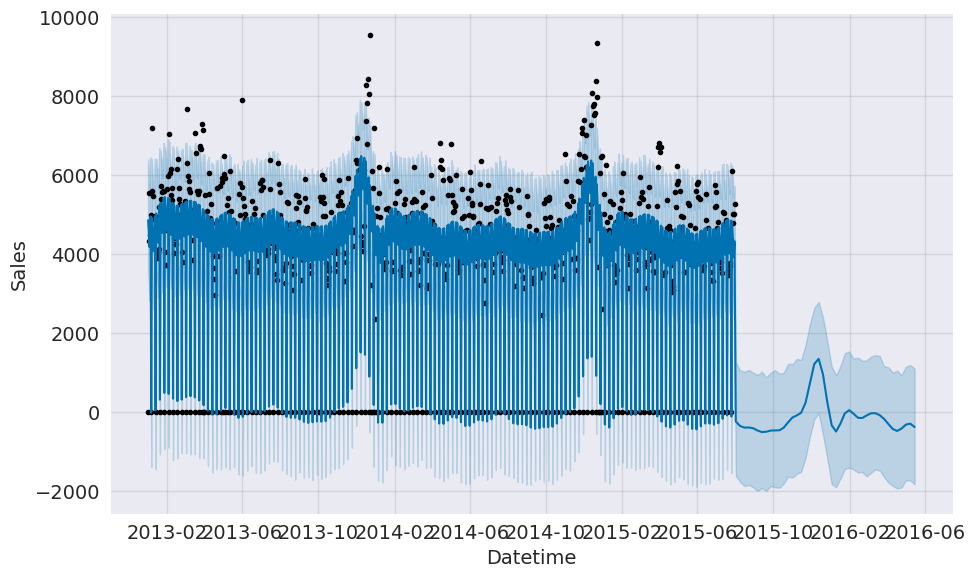

In [ ]:
 fig1=model.plot(forecast,xlabel='Datetime',ylabel='Sales',uncertainty=True)


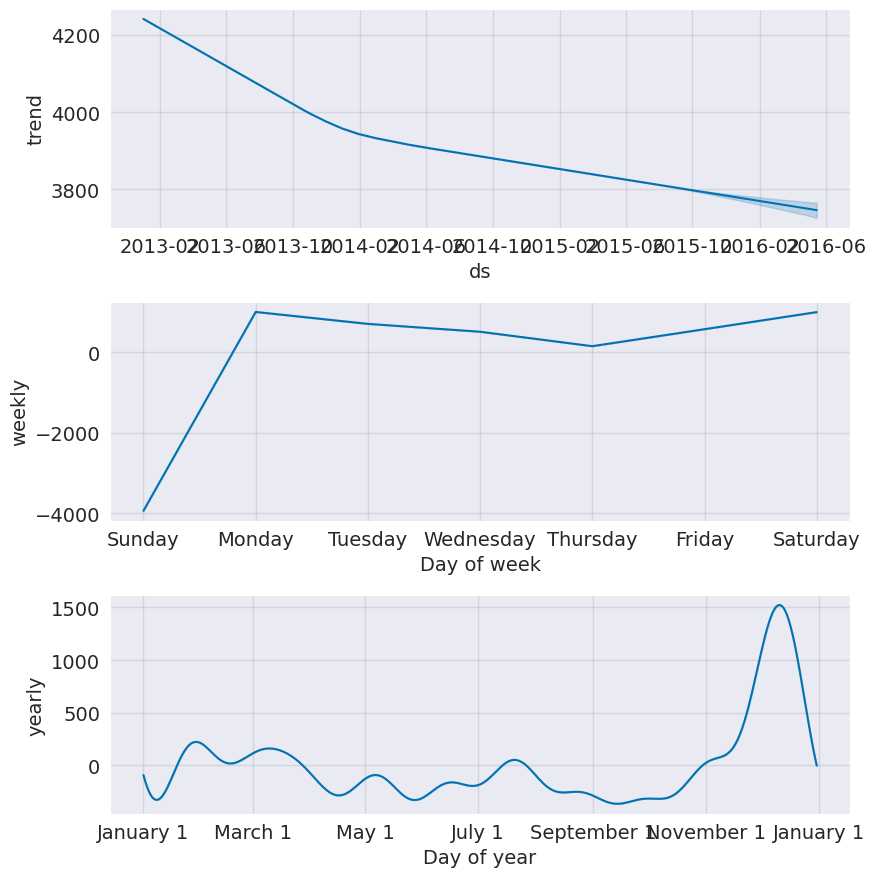

In [ ]:
fig2=model.plot_components(forecast)


In [ ]:
state_dates = df_train[(df_train.StateHoliday == 'a') | (df_train.StateHoliday == 'b') & (df_train.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df_train[df_train.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head(5)

holiday         ds
0  state_holiday 2015-06-04
1  state_holiday 2015-06-04
2  state_holiday 2015-06-04
3  state_holiday 2015-06-04
4  state_holiday 2015-06-04

In [ ]:
model = Prophet(interval_width=0.95, holidays = holidays)
model.fit(df_train_sales)

# dataframe that extends into future 6 weeks
future_dates = model.make_future_dataframe(periods = 42)

print("First week to forecast.")
future_dates.tail(7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdujux5yr/_yg_w_lt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdujux5yr/plggt0uq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35882', 'data', 'file=/tmp/tmpdujux5yr/_yg_w_lt.json', 'init=/tmp/tmpdujux5yr/plggt0uq.json', 'output', 'file=/tmp/tmpdujux5yr/prophet_modellqwlvkig/prophet_model-20230623145802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:58:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


First week to forecast.


ds
977 2015-09-05
978 2015-09-06
979 2015-09-07
980 2015-09-08
981 2015-09-09
982 2015-09-10
983 2015-09-11

In [ ]:
forecast = model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds         yhat   yhat_lower   yhat_upper
977 2015-09-05  4267.012362  2299.129702  6185.922569
978 2015-09-06  -673.175910 -2586.790153  1312.702805
979 2015-09-07  4227.596276  2341.220648  6171.524936
980 2015-09-08  3892.187017  1941.578244  5932.936327
981 2015-09-09  3748.758196  1699.959005  5734.821234
982 2015-09-10  3544.564748  1505.534939  5585.746126
983 2015-09-11  3839.109824  1794.930718  5886.131416

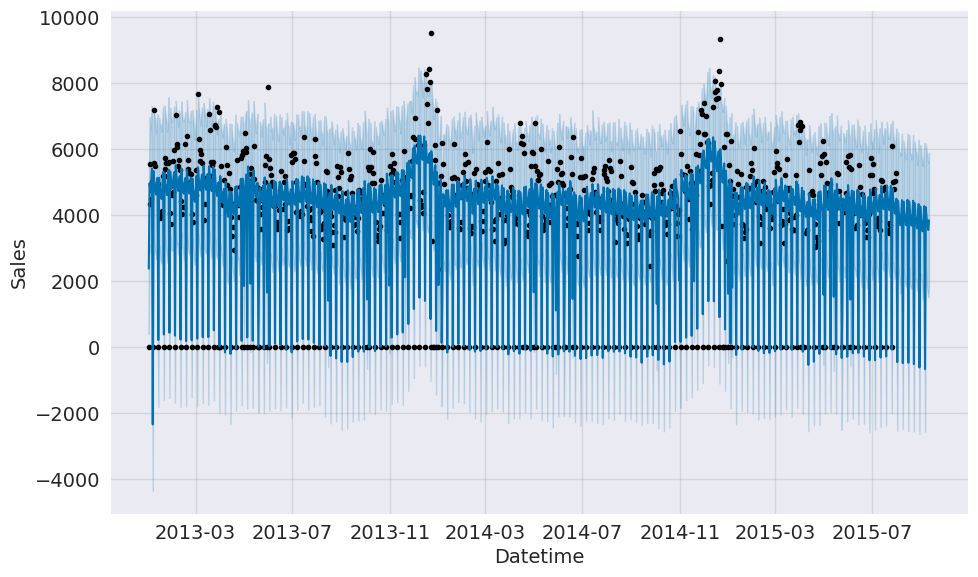

In [ ]:
fig3=model.plot(forecast,xlabel='Datetime',ylabel='Sales',uncertainty=True);


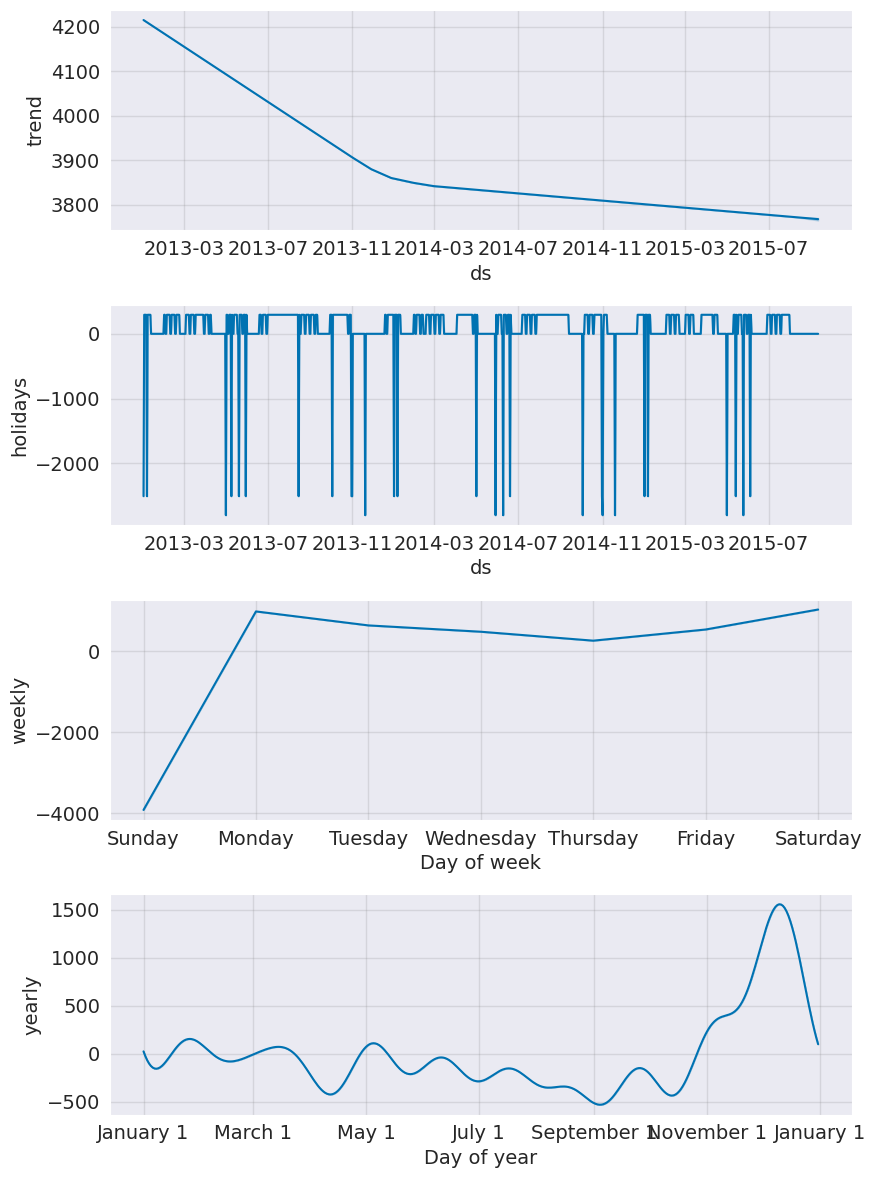

In [ ]:
fig2=model.plot_components(forecast)


In [ ]:
len(df_test),

(41088, 984)

In [ ]:
future_dates_test = df_test.loc[:, ['Date']].rename(columns = {'Date': 'ds'})
print(f"len of future_dates_test is {len(future_dates_test) }")
future_dates_test.head()


len of future_dates_test is 41088


ds
0  2015-09-17
1  2015-09-17
2  2015-09-17
3  2015-09-17
4  2015-09-17

In [ ]:
y_test_pred = model.predict(future_dates_test)

In [ ]:
len(y_test_pred['yhat'])

41088

In [ ]:
y_test_pred_yhat = y_test_pred[['yhat']]
print(f"I predicted {len(y_test_pred_yhat)}")
y_test_pred_yhat

I predicted 41088


yhat
0      4490.464842
1      4490.464842
2      4490.464842
3      4490.464842
4      4490.464842
...            ...
41083  3720.706348
41084  3720.706348
41085  3720.706348
41086  3720.706348
41087  3720.706348

[41088 rows x 1 columns]

In [ ]:
submission_df = y_test_pred_yhat.loc[:, ['yhat']].rename(columns = {'yhat': 'Sales'})
submission_df['Id'] = submission_df.index+1
submission_df.head()
submission_df.to_csv("submission.csv", index=False)
# best_model.save_model("xgboost_model2.bin")


In [ ]:
submission_df.head()

Sales  Id
0  4490.464842   1
1  4490.464842   2
2  4490.464842   3
3  4490.464842   4
4  4490.464842   5